<a href="https://colab.research.google.com/github/JhandryChimbo/machine_learning/blob/main/_downloads/c029676472d90691aa145c6fb97a61c3/neural_networks_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

Neural Networks
===============

Neural networks can be constructed using the `torch.nn` package.

Now that you had a glimpse of `autograd`, `nn` depends on `autograd` to
define models and differentiate them. An `nn.Module` contains layers,
and a method `forward(input)` that returns the `output`.

For example, look at this network that classifies digit images:

![convnet](https://pytorch.org/tutorials/_static/img/mnist.png)

It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

-   Define the neural network that has some learnable parameters (or
    weights)
-   Iterate over a dataset of inputs
-   Process input through the network
-   Compute the loss (how far is the output from being correct)
-   Propagate gradients back into the network's parameters
-   Update the weights of the network, typically using a simple update
    rule: `weight = weight - learning_rate * gradient`

Define the network
------------------

Let's define this network:


In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

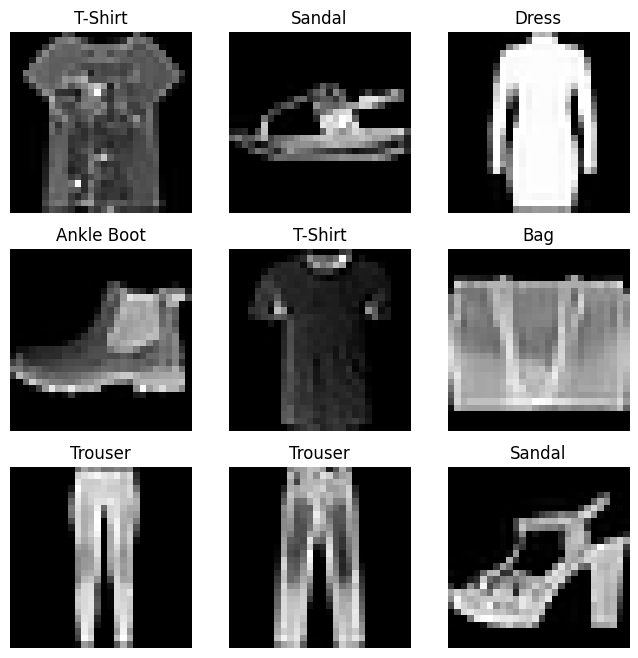

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


You just have to define the `forward` function, and the `backward`
function (where gradients are computed) is automatically defined for you
using `autograd`. You can use any of the Tensor operations in the
`forward` function.

The learnable parameters of a model are returned by `net.parameters()`


In [7]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


Let\'s try a random 32x32 input. Note: expected input size of this net
(LeNet) is 32x32. To use this net on the MNIST dataset, please resize
the images from the dataset to 32x32.


In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


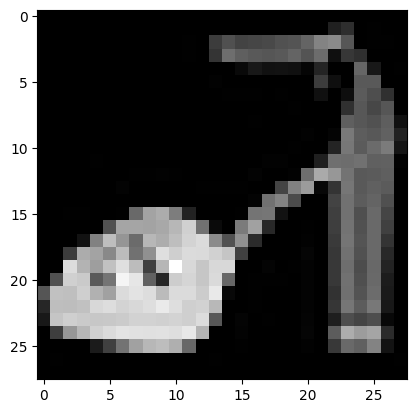

Label: 5


In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [10]:
train_features.shape

torch.Size([64, 1, 28, 28])

In [11]:
train_features[0].unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [12]:
out = net(train_features[0].unsqueeze(0))
print(out.shape)

torch.Size([1, 10])


Zero the gradient buffers of all parameters and backprops with random
gradients:


In [13]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p><code>torch.nn</code> only supports mini-batches. The entire <code>torch.nn</code>package only supports inputs that are a mini-batch of samples, and nota single sample.For example, <code>nn.Conv2d</code> will take in a 4D Tensor of<code>nSamples x nChannels x Height x Width</code>.If you have a single sample, just use <code>input.unsqueeze(0)</code> to adda fake batch dimension.</p>

</div>

Before proceeding further, let\'s recap all the classes you've seen so
far.

**Recap:**

:   -   `torch.Tensor` - A *multi-dimensional array* with support for
        autograd operations like `backward()`. Also *holds the gradient*
        w.r.t. the tensor.
    -   `nn.Module` - Neural network module. *Convenient way of
        encapsulating parameters*, with helpers for moving them to GPU,
        exporting, loading, etc.
    -   `nn.Parameter` - A kind of Tensor, that is *automatically
        registered as a parameter when assigned as an attribute to a*
        `Module`.
    -   `autograd.Function` - Implements *forward and backward
        definitions of an autograd operation*. Every `Tensor` operation
        creates at least a single `Function` node that connects to
        functions that created a `Tensor` and *encodes its history*.

**At this point, we covered:**

:   -   Defining a neural network
    -   Processing inputs and calling backward

**Still Left:**

:   -   Computing the loss
    -   Updating the weights of the network

Loss Function
=============

A loss function takes the (output, target) pair of inputs, and computes
a value that estimates how far away the output is from the target.

There are several different [loss
functions](https://pytorch.org/docs/nn.html#loss-functions) under the nn
package . A simple loss is: `nn.MSELoss` which computes the mean-squared
error between the output and the target.

For example:


In [14]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

TypeError: conv2d() received an invalid combination of arguments - got (method, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!method!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!method!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


Now, if you follow `loss` in the backward direction, using its
`.grad_fn` attribute, you will see a graph of computations that looks
like this:

``` {.sh}
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> flatten -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss
```

So, when we call `loss.backward()`, the whole graph is differentiated
w.r.t. the neural net parameters, and all Tensors in the graph that have
`requires_grad=True` will have their `.grad` Tensor accumulated with the
gradient.

For illustration, let us follow a few steps backward:


In [ ]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop
========

To backpropagate the error all we have to do is to `loss.backward()`.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.

Now we shall call `loss.backward()`, and have a look at conv1\'s bias
gradients before and after the backward.


In [ ]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

Now, we have seen how to use loss functions.

**Read Later:**

> The neural network package contains various modules and loss functions
> that form the building blocks of deep neural networks. A full list
> with documentation is [here](https://pytorch.org/docs/nn).

**The only thing left to learn is:**

> -   Updating the weights of the network

Update the weights
==================

The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

``` {.python}
weight = weight - learning_rate * gradient
```

We can implement this using simple Python code:

``` {.python}
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. To enable
this, we built a small package: `torch.optim` that implements all these
methods. Using it is very simple:

``` {.python}
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update
```


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Observe how gradient buffers had to be manually set to zero using<code>optimizer.zero_grad()</code>. This is because gradients are accumulatedas explained in the <a href="">Backprop</a> section.</p>

</div>

